# MMLDT-CSET 2021

# Short course 3:

# Elastic energy functional - soblev training

Instructors: Prof. Waiching Sun, Zeyu Xiong (Columbia University)

## Outline

1. Data generation

2. Soblev training

3. Uniaxial testing

## 1. Data generation

The hyperelastic energy functional is shown below.

$$
W(\boldsymbol{F})=\frac{\kappa}{2} (J-1)^2 + \mu(\frac{I_1}{J^{2/3}}-3)
$$

$$
\boldsymbol{P}=\frac{\partial W}{\partial\boldsymbol{F}}=
\kappa J(J-1)\boldsymbol{F}^{-T} + \frac{\mu}{J^{2/3}}(\boldsymbol{F}-\frac{1}{3} I_1\boldsymbol{F}^{-T})
$$

where $\kappa$ is the bulk modulus, $\mu$ is the shear modulus, $\boldsymbol{F}$ is the deformation gradient, $W$ is the energy functional, $\boldsymbol{P}$ is the 1st Piola-Kirchhoff stress tensor, $I_1=\boldsymbol{F}:\boldsymbol{F}$, $J=\det(\boldsymbol{F})$.

In [90]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import savemat


k = 1./3     # bulk modulus
mu = 0.5    # shear modulus
F_train = []
P_train = []
W_train = []
for m in range(10100):
	F = (np.random.rand(2,2)-0.5)*0.75+np.eye(2)
# 	F = F*(1+np.random.rand())/2


	J = np.linalg.det(F)
	I1 = np.linalg.norm(F)**2+1
	W = k/2*(J-1)**2+mu/2*(I1/J**(2/3)-3)
	P = ( k*J*(J-1)-1/3*mu/J**(2/3)*I1 )*np.linalg.inv(F).transpose() + mu/J**(2/3)*F

	F_train.append(F)
	W_train.append(W)
	P_train.append(P)
F_train = np.array(F_train)
W_train = np.array(W_train)
P_train = np.array(P_train)

F_test = F_train[10000:10100]
W_test = W_train[10000:10100]
P_test = P_train[10000:10100]

F_train = F_train[0:10000]
W_train = W_train[0:10000]
P_train = P_train[0:10000]

data = {'F_train': F_train, 'F_test': F_test,
	'W_train': W_train, 'W_test': W_test,
	'P_train': P_train, 'P_test': P_test}

savemat('dataset.mat',data)

## 2. Soblev training

The data is loaded and preprocessed into the set of 2nd Piola-Kirchhoff stress tensor $\boldsymbol{S}$ and Green-Lagrange strain tensor $\boldsymbol{E}$. 

$$
\boldsymbol{C}=\boldsymbol{F}^T\boldsymbol{F}, \boldsymbol{E}=\frac{\boldsymbol{C}-\boldsymbol{I}}{2}
$$
$$
\boldsymbol{S}=\frac{\partial W}{\partial\boldsymbol{E}}=\boldsymbol{F}^{-1}\boldsymbol{P}
$$

where $\boldsymbol{C}$ is called Cauchy-Green tensor. By doing so, the data used for soblev training become symmetric tensors, which reduces the dimension of the training data.

$$
X_{train}^{(i)}=\begin{bmatrix}
E_{11}^{(i)}\\
E_{22}^{(i)}\\
2E_{12}^{(i)}\\
\end{bmatrix}
$$

$$
y_{train}^{(i)}=W^{(i)}
$$

$$
dX_{train}^{(i)}=\frac{\partial y_{train}^{(i)}}{\partial X_{train}^{(i)}}=\begin{bmatrix}
S_{11}^{(i)}\\
S_{22}^{(i)}\\
S_{12}^{(i)}\\
\end{bmatrix}
$$


In [91]:
import torch
import torch.nn as nn
import numpy as np

from MLP import MLP
from scipy.io import loadmat

train_size = 10000

# load data
data = loadmat('dataset.mat')
X_train = np.zeros((train_size,3)).astype(np.float32)
X_test = np.zeros((100,3)).astype(np.float32)
y_train = np.zeros((train_size,1)).astype(np.float32)
y_test = np.zeros((100,1)).astype(np.float32)
dX_train = np.zeros((train_size,3)).astype(np.float32)
dX_test = np.zeros((100,3)).astype(np.float32)

F_train = data['F_train']
P_train = data['P_train']
W_train = data['W_train']
for m in range(train_size):
    F = F_train[m].reshape((2,2))
    C = np.dot(F.transpose(),F)
    E = (C-np.eye(2))/2
    S = np.dot(np.linalg.inv(F), P_train[m].reshape((2,2)))
    X_train[m] = [E[0][0], E[1][1], 2*E[0][1]]
    dX_train[m] = [S[0][0], S[1][1], S[0][1]]
    y_train[m][0] = W_train[0][m]

F_test = data['F_test']
P_test = data['P_test']
W_test = data['W_test']
for m in range(100):
    F = F_test[m].reshape((2,2))
    C = np.dot(F.transpose(),F)
    E = (C-np.eye(2))/2
    S = np.dot(np.linalg.inv(F), P_test[m].reshape((2,2)))
    X_test[m] = [E[0][0], E[1][1], 2*E[0][1]]
    dX_test[m] = [S[0][0], S[1][1], S[0][1]]
    y_test[m][0] = W_test[0][m]


X_train = torch.from_numpy(X_train)
X_train.requires_grad= True
X_test = torch.from_numpy(X_test)
X_test.requires_grad = True
dX_train = torch.from_numpy(dX_train)
dX_test = torch.from_numpy(dX_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

Compared to the regular supervised learning, the soblev training has the loss function with an additional term  penalizing the difference in the gradient of the functional.

$$
L=\frac{1}{m}\sum_{i=1}^m ||W^{(i)}-\hat{W}^{(i)}||^2+\frac{1}{m}\sum_{i=1}^m||\frac{\partial W^{(i)}}{\partial\boldsymbol{E}}-\frac{\partial \hat{W}^{(i)}}{\partial\boldsymbol{E}}||^2
$$

In [92]:
learning_rate = 0.005
num_epochs = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP([3,32,32,1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    
    X_train = torch.from_numpy(X_train.detach().numpy())
    X_train.requires_grad=True
    y_pred = model(X_train)
    external_grad = torch.ones_like(y_pred)
    y_pred.backward(gradient=external_grad, retain_graph=True, create_graph=True)
    dX_pred = X_train.grad 
    
    loss = criterion(dX_pred, dX_train) + criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_running_loss = loss.detach().item()


    y_pred = model(X_test)
    external_grad = torch.ones_like(y_pred)
    y_pred.backward(gradient=external_grad, retain_graph=False)
    dX_pred = X_test.grad
    test_loss = criterion(dX_pred,dX_test) + criterion(y_pred, y_test)
    X_test.grad.data.zero_()
    
    if epoch%100==0:    
        print('Epoch: %d | Loss = %.4f | Test Loss = %.4f'%(epoch, train_running_loss, test_loss))

torch.save(model.state_dict(), './model_2d')

Epoch: 0 | Loss = 0.2066 | Test Loss = 0.1834
Epoch: 100 | Loss = 0.0316 | Test Loss = 0.0414
Epoch: 200 | Loss = 0.0080 | Test Loss = 0.0123
Epoch: 300 | Loss = 0.0080 | Test Loss = 0.0071
Epoch: 400 | Loss = 0.0026 | Test Loss = 0.0036
Epoch: 500 | Loss = 0.0020 | Test Loss = 0.0023
Epoch: 600 | Loss = 0.0016 | Test Loss = 0.0016
Epoch: 700 | Loss = 0.0013 | Test Loss = 0.0012
Epoch: 800 | Loss = 0.0011 | Test Loss = 0.0009
Epoch: 900 | Loss = 0.0011 | Test Loss = 0.0008


## 3. Uniaxial testing

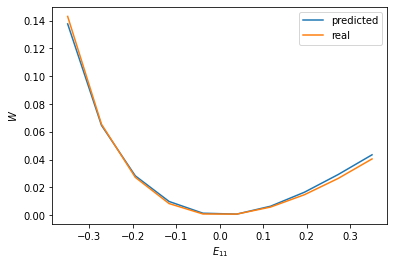

In [96]:
import torch
from MLP import MLP
import numpy as np
import matplotlib.pyplot as plt


model = MLP().to('cpu')
model.load_state_dict(torch.load('./model_2d'))
model.eval()

k = 1./3
mu = 0.5
# test with uniaxial strain
E11= np.linspace(-0.35, 0.35 ,10).astype(np.float32)
eps = np.zeros((10,3)).astype(np.float32)
eps[:,0] = E11
eps[:,1] = 0
eps[:,2] = 0
eps = torch.from_numpy(eps)
eps.requires_grad=True
Psi = model(eps)
Psi.backward(gradient=torch.ones_like(Psi))
stress=eps.grad

plt.figure(1)
plt.plot(E11, Psi.detach().numpy().reshape(-1))
J = np.sqrt(1+2*E11)
Psi_true = k/2*(J-1)**2 + mu/2*((3+2*E11)/J**(2/3) - 3)
plt.plot(E11, Psi_true)
plt.xlabel('$E_{11}$')
plt.ylabel('$W$')
plt.legend(['predicted', 'real'])

plt.figure(2)
plt.plot(E11, stress.detach().numpy()[:,0])
stress_true = k*J*(J-1)/(1+2*E11) + mu/J**(2/3) * 4/3*E11/(1+2*E11)
plt.plot(E11, stress_true)
plt.xlabel('$E_{11}$')
plt.ylabel('$S_{11}$')
plt.legend(['predicted', 'real'])
plt.show()


## 4. Validation of convexity

Sometimes the convexity of the energy functional is desired. However, the soblev training results may not guarantee convexity, as shown by the test code below.

In [119]:
import torch
from MLP import MLP
import numpy as np
import matplotlib.pyplot as plt


model = MLP().to('cpu')
model.load_state_dict(torch.load('./model_2d'))
model.eval()

data = loadmat('dataset.mat')
F_test = data['F_test']
P_test = data['P_test']
W_test = data['W_test']

count=0
for t in range(10000):
    I = np.random.choice(100,2)
    F0 = F_test[I[0]] 
    E0 = (np.dot(F0.transpose(),F0)-np.eye(2))/2
    X0 = np.array([[E0[0,0], E0[1,1], 2*E0[0,1]]])
    X0 = torch.tensor(X0.astype(np.float32))
    X0.requires_grad = True
    W0 = model(X0)
    W0.backward(gradient=torch.ones_like(W0))
    S0 = X0.grad.detach().numpy()
    S0 = np.array([ [S0[0,0], S0[0,2]], [S0[0,2], S0[0,1]] ])
    P0 = np.dot(F0,S0)
    
    F1 = F_test[I[1]]
    E1 = (np.dot(F1.transpose(),F1)-np.eye(2))/2
    X1 = np.array([[E1[0,0], E1[1,1], 2*E1[0,1]]])
    X1 = torch.tensor(X1.astype(np.float32))
    W1 = model(X1)
    
    if W1-W0-np.trace(np.dot(S0.transpose(), E1-E0)) < 0:
        count += 1
print('number of exceptions:', count)


number of exceptions: 3


To enforce convexity, an additional term penalizing the nonconvex elastic energy is added.
$$
L=\frac{1}{m}\sum_{i=1}^m ||W^{(i)}-\hat{W}^{(i)}||^2+\frac{1}{m}\sum_{i=1}^m||\frac{\partial W^{(i)}}{\partial\boldsymbol{E}}-\frac{\partial \hat{W}^{(i)}}{\partial\boldsymbol{E}}||^2 + \frac{1}{m}\sum_{i=1}^m relu[\boldsymbol{\hat{S}}^{(i)}:\delta\boldsymbol{E}^{(i)}+\hat{W}^{(i)}(\boldsymbol{E}^{(i)})-\hat{W}^{(i)}(\boldsymbol{E}^{(i)}+\delta\boldsymbol{E}^{(i)})]
$$

In [114]:
learning_rate = 0.005
num_epochs = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP([3,32,32,1]).to(device)
criterion = nn.MSELoss()
relu = nn.ReLU()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    
    X_train = X_train.detach().numpy()
    X_train_1 = X_train + np.random.rand(10000,3).astype(np.float32)*0.05
    X_train = torch.tensor(X_train)
    X_train_1 = torch.tensor(X_train_1)
    X_train.requires_grad=True
    y_pred = model(X_train)
    external_grad = torch.ones_like(y_pred)
    y_pred.backward(gradient=external_grad, retain_graph=True, create_graph=True)
    dX_pred = X_train.grad 
    y_pred_1 = model(X_train_1)
    
    S_dot_dE = torch.sum(dX_pred*(X_train_1-X_train), 1)
    loss = criterion(dX_pred, dX_train) + criterion(y_pred, y_train) + torch.mean(relu(y_pred-y_pred_1+S_dot_dE))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_running_loss = loss.detach().item()


    y_pred = model(X_test)
    external_grad = torch.ones_like(y_pred)
    y_pred.backward(gradient=external_grad, retain_graph=False)
    dX_pred = X_test.grad
    test_loss = criterion(dX_pred,dX_test) + criterion(y_pred, y_test)
    X_test.grad.data.zero_()
    
    if epoch%100==0:    
        print('Epoch: %d | Loss = %.4f | Test Loss = %.4f'%(epoch, train_running_loss, test_loss))

torch.save(model.state_dict(), './model_2d_1')

Epoch: 0 | Loss = 0.2109 | Test Loss = 0.1834
Epoch: 100 | Loss = 0.0352 | Test Loss = 0.0372
Epoch: 200 | Loss = 0.0122 | Test Loss = 0.0074
Epoch: 300 | Loss = 0.0098 | Test Loss = 0.0034
Epoch: 400 | Loss = 0.0089 | Test Loss = 0.0023
Epoch: 500 | Loss = 0.0084 | Test Loss = 0.0013
Epoch: 600 | Loss = 0.0082 | Test Loss = 0.0009
Epoch: 700 | Loss = 0.0081 | Test Loss = 0.0008
Epoch: 800 | Loss = 0.0083 | Test Loss = 0.0008
Epoch: 900 | Loss = 0.0080 | Test Loss = 0.0007


By adding the additional term penalizing the nonconvexity, the trained constitutive model passes the convexity test.

In [120]:
import torch
from MLP import MLP
import numpy as np
import matplotlib.pyplot as plt


model = MLP().to('cpu')
model.load_state_dict(torch.load('./model_2d_1'))
model.eval()

data = loadmat('dataset.mat')
F_test = data['F_test']
P_test = data['P_test']
W_test = data['W_test']

count=0
for t in range(10000):
    I = np.random.choice(100,2)
    F0 = F_test[I[0]] 
    E0 = (np.dot(F0.transpose(),F0)-np.eye(2))/2
    X0 = np.array([[E0[0,0], E0[1,1], 2*E0[0,1]]])
    X0 = torch.tensor(X0.astype(np.float32))
    X0.requires_grad = True
    W0 = model(X0)
    W0.backward(gradient=torch.ones_like(W0))
    S0 = X0.grad.detach().numpy()
    S0 = np.array([ [S0[0,0], S0[0,2]], [S0[0,2], S0[0,1]] ])
    P0 = np.dot(F0,S0)
    
    F1 = F_test[I[1]]
    E1 = (np.dot(F1.transpose(),F1)-np.eye(2))/2
    X1 = np.array([[E1[0,0], E1[1,1], 2*E1[0,1]]])
    X1 = torch.tensor(X1.astype(np.float32))
    W1 = model(X1)
    
    if W1-W0-np.trace(np.dot(S0.transpose(), E1-E0)) < 0:
        count += 1
print('number of exceptions:', count)




number of exceptions: 0
